In [1]:
from os import listdir
from os.path import isfile, join
from PIL import Image
import sys
%matplotlib inline 
from pathlib import Path
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np 
#from comet_ml import Experiment
import os
import copy
from sklearn.utils import shuffle

np.random.seed(20)
from tensorflow.keras.utils import to_categorical
# from keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.datasets import load_files   
#from tensorflow.keras.utils import np_utils
from glob import glob
from tensorflow.keras import applications
#from keras import optimizers

from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D, Input
# from keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import SGD, Adam
# from keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications.xception import Xception
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
from tqdm import tqdm_notebook

import cv2

from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!unzip '/content/drive/My Drive/Colab Notebooks/emotion detection/test.zip' -d "/content"

In [2]:
#this function returns the CNN model
def get_CNN():
  model = models.Sequential()

  model.add(layers.Conv2D(64, kernel_size=3, activation='linear', padding='same', input_shape=(350, 350, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  # model.add(layers.Dropout(0.5))
  model.add(layers.MaxPool2D(2))

  model.add(layers.Conv2D(128, kernel_size=3, activation='linear', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.MaxPool2D(2))

  model.add(layers.Conv2D(256, kernel_size=3, activation='linear', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Conv2D(256, kernel_size=3, activation='linear', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.MaxPool2D(2))

  model.add(layers.Conv2D(512, kernel_size=3, activation='linear', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.MaxPool2D(2))

  model.add(layers.Conv2D(512, kernel_size=3, activation='linear', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.MaxPool2D(2))


  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(10, activation='softmax'))
  return model


In [3]:
#This model returns out VGG based model
def get_VGG():

  input_shape = (350, 350, 1)
  img_input = Input(shape=input_shape, name = 'grayscale_input_layer')
  y = Conv2D(3, (3,3),  padding= 'same', name = 'grayscale_RGB_layer')(img_input)

  vgg_conv = VGG16(input_shape=(350, 350, 3), include_top=False, pooling="max")

  y = vgg_conv(y)

  y = Dense(512, activation='relu')(y) 
  y = Dense(256, activation='relu')(y) 
  y = Dense(128, activation='relu')(y) 


  y = Dense(10, activation="softmax")(y)
  model = Model(img_input, y)
  return model

In [4]:
base_path = '/content/drive/My Drive/Colab Notebooks/emotion detection/'
result = pd.read_csv( base_path + "gendata.csv") 

img_path = "/content/images/"
all_images = []

for img in result["image"]: 
    temp = cv2.imread(img_path + img,0)
    if np.shape(temp) != (350,350):
        try:    
            temp = temp[:350,:350]
            a = np.shape(temp)[0]
            b = np.shape(temp)[1]

            temp = np.pad(temp, pad_width = ((350 - a,0),(350 - b,0)))
        except:
            temp = np.zeros((350,350))
    all_images.append(temp)
    

print(np.shape(all_images))


(13861, 350, 350)


In [5]:

all_emotions = copy.deepcopy(result["emotion"])    
all_emotions = np.array(all_emotions)

emotion_array = ["\U0001f642", "\U0001f620", "\U0001F644", "\U0001f616",
                 "\U0001f628","\U0001F610", "\U0001f641","\U0001f633",
                 "\U0001f62c", "\U0001f61c"]

emotion_dic = {"\U0001f642":0, "\U0001f620":1, "\U0001F644":2, "\U0001f616":3,
                 "\U0001f628":4,"\U0001F610":5, "\U0001f641":6,"\U0001f633":7,
                 "\U0001f62c":8, "\U0001f61c":9}

for i in range(len(all_emotions)):
    all_emotions[i] = emotion_dic[all_emotions[i]]

all_emotions = to_categorical(all_emotions)


X_train, X_val, y_train, y_val = train_test_split(all_images, all_emotions, random_state=42, test_size=0.2)

In [6]:
test_images= []
test_path =  "/content/test/"
for f in listdir(test_path):
    temp = cv2.imread(test_path+ f,0)
    if np.shape(temp) != (350,350):
        try:
            temp = temp[:350,:350]
            a = np.shape(temp)[0]
            b = np.shape(temp)[1]
            temp = np.pad(temp, pad_width = ((350 - a,0),(350 - b,0) ))
        except:
            temp = np.zeros((350,350))
       
    test_images.append(temp)
    
test_images = np.stack(test_images, axis=0 )
test_images = np.expand_dims(test_images, axis=-1)
print(np.shape(test_images))


(263, 350, 350)


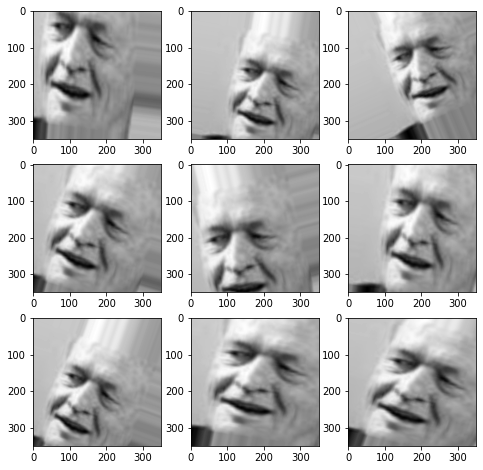

In [7]:
#Image Augmentation
train_datagen = ImageDataGenerator(
rescale=1./255,    
rotation_range=30,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=False,
fill_mode='nearest') 

val_datagen = ImageDataGenerator(rescale=1./255)

x = all_images[3]
x = np.expand_dims(x, axis=-1)
x= np.expand_dims(x, axis=0)
i = 1


fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for batch in train_datagen.flow(x, batch_size=32):
    # plt.figure(i)
    fig.add_subplot(rows, columns, i)
    imgplot = plt.imshow(image.array_to_img(batch[0]), cmap='gray')
    i += 1
    if i % (rows*columns + 1) == 0:
        break
plt.show()

In [8]:
X_train = np.expand_dims(X_train, axis=-1)

X_val = np.expand_dims(X_val, axis=-1)
train_datagen.fit(X_train)
val_datagen.fit(X_val)

In [9]:
model_type = 'VGG'

if model_type == 'CNN':
  model = get_CNN()
elif model_type == 'VGG':
  model = get_VGG()
 
VERSION = model_type + '_V25_aug_'
# opt = 'sgd'
learning_rate = 1e-2
decay_rate = 0.0
momentum = 0.0
bs = 4

VERSION += '_opt_' + 'sgd'
VERSION += '_bs_' + str(bs)
VERSION += '_lr_' + str(learning_rate)
VERSION += '_dr_' + str(decay_rate)
VERSION += '_m_' + str(momentum)
#opt = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
opt = SGD()
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

filepath=  "h_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
grayscale_input_layer (Input [(None, 350, 350, 1)]     0         
_________________________________________________________________
grayscale_RGB_layer (Conv2D) (None, 350, 350, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290  

In [13]:
output_dim = nb_classes = 10 
nb_epoch =200

model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=bs), 
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=bs),
                    validation_steps = len(X_val)/bs,
                    steps_per_epoch = len(X_train)/bs, 
                    epochs=nb_epoch,
                    callbacks=callbacks_list)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
2772/2772 [==============================] - 284s 100ms/step - loss: 1.0877 - accuracy: 0.4786 - val_loss: 1.0191 - val_accuracy: 0.4144

Epoch 00001: val_accuracy improved from -inf to 0.41435, saving model to h_weights-improvement-01-0.41.hdf5
Epoch 2/200
2772/2772 [==============================] - 275s 99ms/step - loss: 1.0156 - accuracy: 0.5077 - val_loss: 1.0744 - val_accuracy: 0.4998

Epoch 00002: val_accuracy improved from 0.41435 to 0.49982, saving model to h_weights-improvement-02-0.50.hdf5
Epoch 3/200
2772/2772 [==============================] - 275s 99ms/step - loss: 1.0045 - accuracy: 0.4917 - val_loss: 0.9915 - val_accuracy: 0.5146

Epoch 00003: val_accuracy improved from 0.49982 to 0.51461, saving model to h_weights-improvement-03-0.51.hdf5
Epoch 4/200
2772/2772 [==============================] - 275s 99ms/step - loss: 0.9845 - accuracy: 0.5058 - val_loss: 0.9732 - val_accuracy: 0.5168

Epoch 00004: val_accuracy improved from 0.51461 to 0.51677, saving model 

KeyboardInterrupt: ignored

In [10]:
# load weights
model.load_weights("h_weights-improvement-51-0.87.hdf5")
# Compile model (required to make predictions)

# estimate accuracy on whole dataset using loaded weights
score = model.evaluate(val_datagen.flow(X_val, y_val), verbose=0) 
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.4936741888523102
Test accuracy: 0.8683735728263855


In [42]:
test_result = model.predict(test_images, batch_size=128)
y_pred = np.argmax(test_result, axis=1)


In [41]:
#list of test images in order that were given to the predictor
print(listdir(test_path))

['Prema_18.jpg', 'TM.FE2.197.jpg', 'MallikarjunaRao_10.jpg', 'Brahmanandam_81.jpg', 'NA.SU2.209.jpg', 'FaridaJalal_69.jpg', 'RimiSen_132.jpg', 'KajalAgarwal_19.jpg', '72a.jpg', 'KA.FE2.46.jpg', 'Dileep_60.jpg', 'JAMUNA_284.jpg', 'y12.jpg', 'RamyaKrishna_90.jpg', 'KM.SU2.15.jpg', 'Dileep_65.jpg', 'BomanIrani_9.jpg', 'KA.DI2.43.jpg', 'FaridaJalal_133.jpg', 'KR.DI2.87.jpg', 'y14.jpg', 'KM.NE2.2.jpg', 'y10.jpg', 'NM.SA2.99.jpg', 'Prema_93.jpg', 'TM.AN2.191.jpg', 'y25.jpg', 'y07.jpg', 'y22.jpg', '38a.jpg', 'TM.SU2.188.jpg', 'KR.AN2.84.jpg', 'TM.HA2.181.jpg', 'y21.jpg', 'y30.jpg', 'UY.FE2.153.jpg', '51a.jpg', '200b.jpg', '7b.jpg', '11a.jpg', 'NA.AN2.212.jpg', 'NM.SU2.102.jpg', 'UY.AN2.147.jpg', '132b.jpg', 'BomanIrani_76.jpg', '64a.jpg', 'RimiSen_167.jpg', 'BhanuPriya_15.jpg', 'Brahmanandam_24.jpg', 'y15.jpg', 'Prema_89.jpg', 'y31.jpg', 'NTR_69.jpg', 'JayaBhaduri_2.jpg', 'KR.FE2.90.jpg', 'FaridaJalal_2.jpg', 'KR.HA2.75.jpg', 'y32.jpg', 'Irani_37.jpg', '195a.jpg', '190b.jpg', '141b.jpg', '119

In [40]:
#emojis predicted for each test image respectively
final_result = []
for i in range(len(y_pred)):
  final_result.append(emotion_array[y_pred[i]])
final_result


['😠',
 '😬',
 '😬',
 '😜',
 '😬',
 '😜',
 '🙂',
 '😖',
 '😐',
 '😬',
 '😖',
 '🙂',
 '😠',
 '🙂',
 '😜',
 '😜',
 '😠',
 '😬',
 '😜',
 '😬',
 '😖',
 '😬',
 '😜',
 '😜',
 '😜',
 '😬',
 '😜',
 '😜',
 '😜',
 '😜',
 '😬',
 '😬',
 '😬',
 '😬',
 '😠',
 '😬',
 '😬',
 '😬',
 '😬',
 '😠',
 '😬',
 '😜',
 '😬',
 '😬',
 '😬',
 '😖',
 '😬',
 '😠',
 '😬',
 '😬',
 '😜',
 '😠',
 '😬',
 '😜',
 '😬',
 '😖',
 '😬',
 '😜',
 '😬',
 '😬',
 '😬',
 '😬',
 '😜',
 '😠',
 '😖',
 '😜',
 '😜',
 '😬',
 '😜',
 '🙁',
 '😬',
 '😜',
 '😬',
 '😜',
 '🙂',
 '😜',
 '😜',
 '😜',
 '😜',
 '😠',
 '🙂',
 '😬',
 '😜',
 '😖',
 '🙂',
 '😜',
 '😬',
 '😬',
 '😜',
 '😬',
 '🙂',
 '😬',
 '🙂',
 '🙂',
 '😖',
 '😬',
 '😬',
 '😜',
 '😬',
 '🙂',
 '🙂',
 '😖',
 '😬',
 '🙂',
 '😬',
 '😜',
 '😜',
 '😖',
 '😬',
 '😜',
 '😬',
 '😬',
 '😜',
 '😬',
 '😜',
 '🙂',
 '😜',
 '😬',
 '😬',
 '🙂',
 '🙂',
 '😜',
 '😬',
 '🙂',
 '😬',
 '😬',
 '😬',
 '😖',
 '😜',
 '😜',
 '😬',
 '😜',
 '😠',
 '😜',
 '😬',
 '😬',
 '😜',
 '😜',
 '😬',
 '😜',
 '😜',
 '😜',
 '😜',
 '😠',
 '😜',
 '😜',
 '🙂',
 '😬',
 '😖',
 '🙂',
 '😬',
 '😜',
 '😖',
 '😬',
 '😠',
 '😠',
 '😬',
 '😜',
 '🙂',
 '😠',
 '😬',
 '😖',
 '😜',
 '😬',
 '😬',
 '😬',
 '😖'